# GCN to perform subject classification


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import json
import pickle
import time
from torch_geometric.utils import to_undirected

In [2]:
import torch
from torch_geometric.data import Data
from torch import nn
import sklearn
from sklearn.metrics import f1_score

In [3]:
# carpeta para guardar las predicciones
results_path = "./Predictions/"

# nombre de las predicciones
nombre_predicciones = 'GCN.pkl'

# carpeta donde se toman los datos
carpeta_datos = ".\\Data\\GNN_data\\"

# path y nombre para guardar el modelo
model_path = "./Models/GCN/gcn_model.pth"

# archivo donde se ponen los hyperparameters
hyperparameters_file = "./Models/Hyperparameters/GCN.csv"

## Cargar datos

In [4]:
# cargar los diccionarios de codificacion de id
with open(carpeta_datos + 'encode_mathid_2_nodeid.pkl', 'rb') as f:
    encode_mathid_2_nodeid = pickle.load(f)
    
with open(carpeta_datos + 'decode_nodeid_2_mathid.pkl', 'rb') as f:
    decode_nodeid_2_mathid = pickle.load(f)
    
print(f"Se tienen {len(encode_mathid_2_nodeid)} nodos")

Se tienen 267774 nodos


In [5]:
# cargar los diccionarios de codificacion de subject
with open(carpeta_datos + 'encode_subj_2_idx.pkl', 'rb') as f:
    encode_subj_2_idx = pickle.load(f)
    
with open(carpeta_datos + 'decode_idx_2_subj.pkl', 'rb') as f:
    decode_idx_2_subj = pickle.load(f)
    
# contar los subjects sin el unknown
numero_subjects = len(encode_subj_2_idx) - 1 # -1 por el unknown
    
print(f"Se tienen {numero_subjects} subjects (sin el unknown)")

Se tienen 63 subjects (sin el unknown)


## Create model

In [6]:
# funcion para contar el numero de parametros a entrenar de un modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

# hacer la GNN
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_dims, num_features, num_classes, seed = 1234):
        super().__init__()
        
        # semilla para reproductibilidad
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        
        # hacer una lista con las capas de la red
        self.conv_layers = torch.nn.ModuleList()
        
        # primera capa GCN: num_features -> h1
        self.conv_layers.append(GCNConv(num_features, hidden_dims[0]))
        
        # poner las demas capaas
        for i in range(1, len(hidden_dims)):
            
            # delimitar la capa GCN: h_i-1 -> h_i
            self.conv_layers.append(GCNConv(hidden_dims[i-1], hidden_dims[i]))
        
        
        # clasificador: h_-1 -> 63
        self.classifier = Linear(hidden_dims[-1], num_classes)

        
    def forward(self, data):
        
        # tomar los node features y los edge index del data
        h = data.X
        edge_index = data.edge_index
        
        # pasar las capas gcn
        for conv in self.conv_layers:
            h = torch.tanh(conv(h, edge_index))
                    
        # la ultima capa gcn produce los ultimos embedings h
        # luego estos embedings se pasan por el clasificador
        # para hacer la prediccion
        
        out = self.classifier(h)

        # devolver la prediccion y los ultimos embedings
        return out, h

## Preparar entrenamiento

In [8]:
def train_epoch(model, criterion, optimizer, data):
    '''
    Entrenar por un epoch
    '''
    
    # poner modelo para entrenar
    model.train()
    
    # poner gradientes en cero
    optimizer.zero_grad()
    
    # forward pass
    out, h = model(data)
    
    # calcular la perdida solo con datos en train
    loss = criterion(out[data.train_mask], data.y[data.train_mask].long())
    
    # backward pass, calcular los gradientes
    loss.backward()
    
    # optimizar los parametros con los gradientes
    optimizer.step()
    
    # devolver la train loss de esta epoch
    return loss.item()

In [9]:
def compute_metrics(y_true, y_pred):
    '''
    Funcion que calcula estadisticas de unas predicciones
    '''

    # calcula f1 macro weighted y micro
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    # poner las estadisticas en un diccionario
    dict_results = {
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_micro': f1_micro,
    }

    return dict_results

In [10]:
def evaluate(model, criterion, data):
    '''
    Calcula funcion de perdida y otras estadisticas
    en los datos de validacion
    '''
    
    # poner el modelo en en eval
    model.eval()

    # no calcular grad
    with torch.no_grad():

        # forward pass
        out, h = model(data)

        # calcular la perdida con datos de val
        loss = criterion(out[data.val_mask], data.y[data.val_mask].long())
        
        # tomar las predicciones
        pred = out[data.val_mask].max(dim=1)[1]
        
        # tomar las etiquetas reales para datos de validacion
        true = data.y[data.val_mask]
        
        # calcular estadisticas
        estadisticas_val = compute_metrics(true, pred)

    # devolver la perdida y estadisticas
    return loss.item(), estadisticas_val

In [11]:
def main_train(model, criterion, optimizer, numero_epochs, data, tolerancia):
    '''
    Funcion principal de entrenamiento
    
    Entrena por varios epochs, devuelve metricas
    '''
    
    # ir guardando la mejor metrica el val
    best_metric_val = 0
    
    # ver en cuantos epochs no se mejora esto
    epochs_sin_mejora = 0
    
    # durante el entrenamiento, ir guardando varios valores

    # loss en train
    history_train_loss = []

    # loss en val
    history_train_val = []

    # estadisticas en val
    history_val_stats = []
    
    # hacer todas lass epoch que se quieran
    for idx_epoch in range(1, numero_epochs+1):

        # hacer el train para este epoch
        train_loss = train_epoch(model, criterion, optimizer, data)

        # evaluar en val
        val_loss, val_stats = evaluate(model, criterion, data)

        # agregar a los historicos
        history_train_loss.append(train_loss)
        history_train_val.append(val_loss)
        history_val_stats.append(val_stats)

        # informar sobre esta epoch
        print(f"Epoch: [{idx_epoch}/{numero_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1 macro: {val_stats['f1_macro']:.4f}, Val F1 weighted: {val_stats['f1_weighted']:.4f}, Val F1 micro: {val_stats['f1_micro']:.4f}")

        # ver si es el mejor modelo hasta ahora
        if val_stats['f1_macro'] > best_metric_val:
            
            # indicar en el contador
            epochs_sin_mejora = 0

            # update y guardar
            best_metric_val = val_stats['f1_macro']
            torch.save(model.state_dict(), model_path)
            
        # si no se mejora con respecto al mejor
        else:
            epochs_sin_mejora += 1
            
        # si ya van muchas epochs sin mejora
        if epochs_sin_mejora > tolerancia:
            # dejar de entrenar
            print(f"Se han realizado {epochs_sin_mejora} epochs sin mejorar, terminar de entrenar")
            break

    # end epochs

    # cargar el mejor modelo
    model.load_state_dict(torch.load(model_path))

    # se indica
    print("-"*200)
    print(f"Se carga el mejor modelo que alcanza f1 macro = {best_metric_val}")
    
    
    # hacer un diccionario de estadisticas del entrenamiento
    history = {}

    # poner train y val loss
    history['train_loss'] = history_train_loss
    history['val_loss'] = history_train_val

    # poner las demas metricas
    history['f1_macro'] = [stats['f1_macro'] for stats in history_val_stats]
    history['f1_weighted'] = [stats['f1_weighted'] for stats in history_val_stats]
    history['f1_micro'] = [stats['f1_micro'] for stats in history_val_stats]
    
    # devolver las estadisticas y el mejor modelo
    return history, model

### Graficar estadisticas

In [12]:
sns.set_theme()

In [13]:
def plot_train_val_loss(history):
    '''
    Graficar perdida en train y val durante entrenamiento
    '''
    
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.plot(history['train_loss'], label = "Train loss")
    ax.plot(history['val_loss'], label = "Val loss")
    ax.set_title("Loss during training")

    ax.legend()
    plt.show()

In [14]:
def plot_val_stats(history):
    '''
    Graficar estadisticas en datos val durante entrenamiento
    '''
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    # f1_macro
    ax[0].plot(history['f1_macro'])
    ax[0].set_title("F1 macro")

    # f1_weighted
    ax[1].plot(history['f1_weighted'])
    ax[1].set_title("F1 weighted")

    # f1_micro
    ax[2].plot(history['f1_micro'])
    ax[2].set_title("F1 micro")
    
    fig.suptitle("Validation statistics during trainig")

    plt.show()

### Predecir 

In [15]:
def predecir_evaluar(model, mask, data):
    '''
    Dado un mask (puede ser train o val)
    Hace las predicciones, calcula estadisticas de estas
    '''
    
    # poner el modelo en en eval
    model.eval()

    # no calcular grad
    with torch.no_grad():

        # forward pass
        out, h = model(data)
        
        # tomar las predicciones, solo del mask correspondiente
        pred = out[mask].max(dim=1)[1]
        
        # tomar las etiquetas reales para esos datos
        true = data.y[mask]
        
        # calcular estadisticas
        estadisticas = compute_metrics(true, pred)

    # devolver las estadisticas
    return estadisticas

In [16]:
def predicciones_full_data(model, data):
    '''
    Hace predicciones para todos los datos
    Se guardan en la ruta correespondiente, como un diccionario
    '''

    # poner el modelo en en eval
    model.eval()

    # no calcular grad
    with torch.no_grad():

        # forward pass
        out, h = model(data)

        # tomar las predicciones de todos los datos
        pred = out.max(dim=1)[1]

    # poner las predicciones en formato de diccionario
    # math_id: prediccion
    predicciones_finales = dict()

    # recordar que se tiene un diccionario que nos da el math_id de cada indice
    # tambien se tiene un diccionario que da el subject de cada indice

    # iterar en las predicciones
    for idx_node, prediction in enumerate(pred.numpy()):

        # tomar el nodo del matematico
        math_id = decode_nodeid_2_mathid[idx_node]

        # tomar el subject
        subject = decode_idx_2_subj[prediction]

        # agregar la entrada
        predicciones_finales[math_id] =  subject
    # end for
    
    # guardar estas predicciones
    with open(results_path + nombre_predicciones, 'wb') as f:
        pickle.dump(predicciones_finales, f)

### Actualizar hyperparameters

In [18]:
def update_hyperparameters(metric, params):
    '''
    Al finalizar el entrenamiento
    Guardar las metricas obtenidas para los hyperparametros usados
    '''
    
    # poner los hyperparametros junto con la metrica final obtenida
    dict_info = {
        "FEATURE_SIZE" : params["FEATURE_SIZE"],
        "UNDIRECTED" : str(params["UNDIRECTED"]),
        "CLASS_WEIGHTS" : str(params["CLASS_WEIGHTS"]),
        "LEARNING_RATE" : params["LEARNING_RATE"],
        "WEIGHT_DECAY" : params["WEIGHT_DECAY"],
        "ADAM_EPSILON" : params["ADAM_EPSILON"],
        "NUM_EPOCHS" : params["NUM_EPOCHS"],
        "TOLERANCIA": params["TOLERANCIA"],
        "HIDDEN_DIMS": str(params["HIDDEN_DIMS"]),
        "Val score" : metric
    }

    # hacer un df con esta info
    new_df = pd.DataFrame([dict_info])

    # intenta cargar un archivo existente
    try:

        # leer
        df = pd.read_csv(hyperparameters_file, na_values=None, keep_default_na=False)

        # agregar nueva fila, con la info de esta inferencia
        df = pd.concat([df, new_df], ignore_index=True)
        
        # quitar repetidos
        df = df.drop_duplicates()
        
        # orndeanr
        df = df.sort_values(by='Val score', ascending = False)

        # guardar el archivo modificado
        df.to_csv(hyperparameters_file, index=False)

    # si no se puede abrir, no existe    
    except FileNotFoundError:

        # guardar solo la info de esta iteracion
        new_df.to_csv(hyperparameters_file, index=False)

## Funcion principal

In [19]:
def entrenamiento_completo(params):
    '''
    Realiza todo el entrenamiento de una GCN
    al especificar los hyperparametros
    
    '''
    
    # ver que features se quieren cargar
    if params["FEATURE_SIZE"] == 'small':
        X = torch.load(carpeta_datos + 'node_features_small.pt') 
    elif params["FEATURE_SIZE"] == 'big':
        X = torch.load(carpeta_datos + 'node_features_big.pt') 
    
    # cargar los demas elementos
    edge_index = torch.load(carpeta_datos + 'edge_index.pt')
    y =  torch.load(carpeta_datos + 'y.pt')

    # cargar masks
    train_mask = torch.load(carpeta_datos + 'train_mask.pt')
    val_mask = torch.load(carpeta_datos + 'val_mask.pt')
    test_mask = torch.load(carpeta_datos + 'test_mask.pt')
    useless_mask = torch.load(carpeta_datos + 'useless_mask.pt')

    # crear el objeto data
    data = Data(X = X, y = y, edge_index = edge_index)

    # poner el numero de nodos
    data.num_nodes = X.shape[0]

    # comprobar
    assert X.shape[0] == y.shape[0]

    # agregar los masks
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    data.useless_mask = useless_mask

    # ver que este bien
    data.validate(raise_on_error=True)

    # si se quiere no dirigido
    if params["UNDIRECTED"]:
        # poner ambas direcciones
        data.edge_index = to_undirected(data.edge_index)
        
    # --------------------------------------------------------------

    # info basica
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}\n')
    
    # -----------------------------------------------------------
    
    # hacer el modelo
    gcn_model = GCN(params["HIDDEN_DIMS"], num_features = data.X.shape[1], num_classes = numero_subjects)

    # ver
    print(gcn_model)
    print(f'Trainable parameters: {count_parameters(gcn_model)}\n')
    
    # -------------------------------------------------------------------------------------------------
    
    # definir la funcion de perdida

    # tomar todas las etiquetas para entrenamiento en un array
    etiquetas_y = data.y[data.train_mask].numpy()

    # obtnener le peso de cada clase
    pesos_clases = sklearn.utils.class_weight.compute_class_weight(class_weight= params["CLASS_WEIGHTS"],
                                                                   classes= np.arange(numero_subjects), # el numero de labels
                                                                   y= etiquetas_y)

    # convertir a tensor y mover al device
    pesos_clases = torch.tensor(pesos_clases, dtype=torch.float)

    # hacer la funcion de perdida con las pesos
    customized_criterion = nn.CrossEntropyLoss(weight=pesos_clases)
    
    
    # definir el optimizador
    customized_optimizer = torch.optim.Adam(gcn_model.parameters(),
                                            lr= params["LEARNING_RATE"],
                                            weight_decay = params["WEIGHT_DECAY"],
                                            eps = params["ADAM_EPSILON"])
    # ---------------------------------------------------------------------------------
    # contar tiempo de ejecucion
    start_time = time.time()

    # hacer en entrenamiento
    history, model = main_train(gcn_model, customized_criterion, customized_optimizer,
                                params["NUM_EPOCHS"], data, params["TOLERANCIA"])

    # ver el tiempo
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"El entrenamiento duro {round(elapsed_time, 1)} segundos")
    #------------------------------------------------------------------------------------------------
    
    # ver estadisticas del entrenamiento
    plot_train_val_loss(history)
    plot_val_stats(history)
    
    # ver desempeño del modelo entrenado en datos de train
    print("Train data:")
    train_metrics = predecir_evaluar(gcn_model, data.train_mask, data)
    print(train_metrics)
    
    # ver desempeño del modelo entrenado en datos de val
    print("Val data:")
    val_metrics = predecir_evaluar(gcn_model, data.val_mask, data)
    print(val_metrics)
    
    # hacer y guardar las predicciones en todos los datos
    predicciones_full_data(gcn_model, data)
    
    # actualizar el df de hyperparametros, con el valor f1 macro en los datos de val
    update_hyperparameters(val_metrics['f1_macro'], params)

# Seleccionar hyperparametros

In [21]:
hyperparametros = {
    "FEATURE_SIZE" : 'big',           # small para los features pequeños (1500) big para grandes 
    "UNDIRECTED" : True,                # si las aristas del grafo se toman en una direccion o en dos
    "CLASS_WEIGHTS" : None,             # "balanced" para tener pesos en las clases, None para tener pesos uniformes
    "LEARNING_RATE" : 0.01,            
    "WEIGHT_DECAY" : 0,
    "ADAM_EPSILON" : 1e-8,              # 1e-8
    "NUM_EPOCHS" : 100,                  # numero maximo de epochs, si no se termina antes
    "TOLERANCIA": 10,                    # numero de epochs que se hacen sin mejorar para terminar el entrenamiento
    "HIDDEN_DIMS" : [300, 300]        # dimensiones de los node features, obvio delimita el numero de capas
}

# Realizar entrenamiento

Number of nodes: 267774
Number of edges: 562545
Average node degree: 2.10
Number of training nodes: 141345
Training node label rate: 0.53
Has isolated nodes: True
Has self-loops: False
Is undirected: False

GCN(
  (conv_layers): ModuleList(
    (0): GCNConv(108672, 300)
    (1): GCNConv(300, 300)
  )
  (classifier): Linear(in_features=300, out_features=63, bias=True)
)
Trainable parameters: 32711163

Epoch: [1/100], Train Loss: 4.1517, Val Loss: 3.9272, Val F1 macro: 0.2085, Val F1 weighted: 0.4151, Val F1 micro: 0.4804
Epoch: [2/100], Train Loss: 3.9145, Val Loss: 3.1806, Val F1 macro: 0.0467, Val F1 weighted: 0.2365, Val F1 micro: 0.3386
Epoch: [3/100], Train Loss: 3.1497, Val Loss: 2.8264, Val F1 macro: 0.0404, Val F1 weighted: 0.2226, Val F1 micro: 0.3249
Epoch: [4/100], Train Loss: 2.7861, Val Loss: 2.3681, Val F1 macro: 0.1453, Val F1 weighted: 0.3857, Val F1 micro: 0.4859
Epoch: [5/100], Train Loss: 2.3033, Val Loss: 1.9939, Val F1 macro: 0.2875, Val F1 weighted: 0.5661, Val F1 

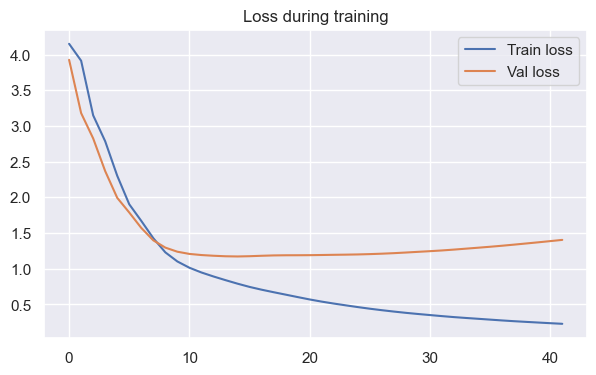

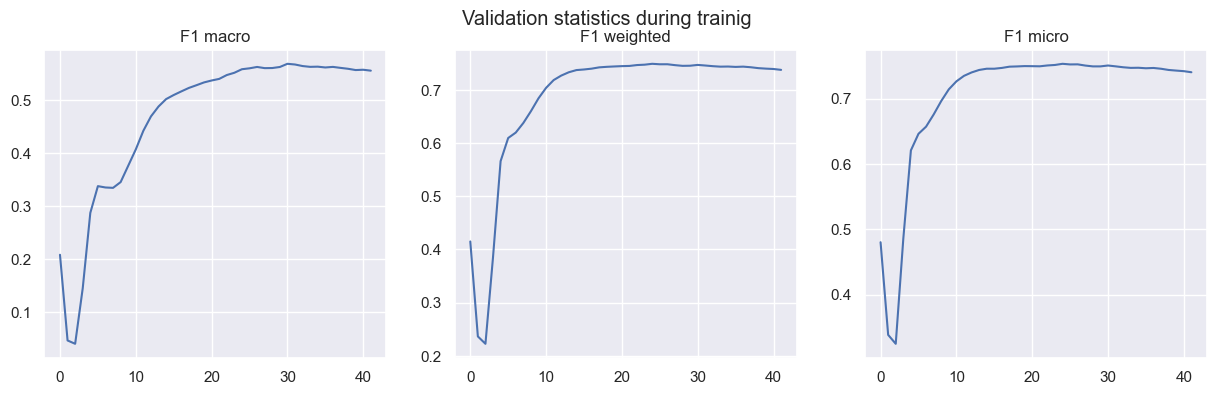

Train data:
{'f1_macro': 0.8225329432271711, 'f1_weighted': 0.901025750813937, 'f1_micro': 0.9023170257172167}
Val data:
{'f1_macro': 0.5688980548054483, 'f1_weighted': 0.7471244427158616, 'f1_micro': 0.7509073543457497}


In [22]:
entrenamiento_completo(hyperparametros)